# Description of variables

The initial version of dataset consists of 10 columns containing the following information:

* Restaurant_id — id of a restaurant / restaurant chain;


* City — restaurant's location (city);


* Cuisine Style — cuisine which a dish can be related to;


* Ranking — restaurant's place in the ranking of all the cities' restaurants;


* Rating — the rating of a restaurant according to TripAdvisor **(this is the target variable)**;


* Price Range — the price range of the restaurant;


* Number of Reviews — number of reviews for a restaurant on TripAdvisor;


* Reviews — info about two first reviews that are displayed on TripAdvisor;


* URL_TA — URL of restaurant's web-page on TripAdvosor;


* ID_TA — restaurant's id in TripAdvisor's Database.

# Import of modules

In [43]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
import missingno as msno
import os
import ast
import warnings
import re
import urllib.request
import requests
import random
from bs4 import BeautifulSoup as BS
from itertools import combinations
from collections import Counter

from sklearn.model_selection import train_test_split  # A tool for splitting a dataset into training and testing samples
from sklearn.ensemble import RandomForestRegressor  # A tool for building a model
from sklearn import metrics  # Tools for model's accuracy measurement

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, MultiLabelBinarizer

%matplotlib inline
sns.set(style='whitegrid')
warnings.simplefilter('ignore')

In [44]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tourism/tourism.txt
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/living-standards/living_standards.txt


Fixing Random seed and package version for reproducible experiments:

In [45]:
RANDOM_SEED = 42

In [46]:
!pip freeze > requirements.txt

In [47]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [50]:
df_train['sample'] = 1  # Train data
df_test['sample'] = 0  # Test data
df_test['Rating'] = 0  # Filling with zeros since there is no data there (needs to be predicted)

data = df_test.append(df_train, sort=False).reset_index(drop=True)

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


# Data preprocessing


Lets get some basic info about the dataset:

In [52]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
42871,id_367,Stockholm,"['Asian', 'Vietnamese', 'Vegetarian Friendly',...",368.0,$$ - $$$,49.0,"[['light and healthy Vietnamese and quick', 'W...",/Restaurant_Review-g189852-d12342209-Reviews-E...,d12342209,1,4.0
27533,id_659,Athens,"['Mediterranean', 'Greek']",660.0,$,49.0,"[['Good food in a quiet neighborhood', 'The re...",/Restaurant_Review-g189400-d1025317-Reviews-Pl...,d1025317,1,4.0
27714,id_5146,Barcelona,['Mediterranean'],5147.0,NaN,5.0,"[[], []]",/Restaurant_Review-g187497-d7777949-Reviews-Ri...,d7777949,1,4.0
32931,id_12756,London,['Gastropub'],12766.0,$$$$,9.0,"[['Cool and not expensive!', 'Very good food a...",/Restaurant_Review-g186338-d731500-Reviews-Dev...,d731500,1,4.0
38195,id_167,Copenhagen,"['Italian', 'Mediterranean', 'European', 'Vege...",168.0,$$ - $$$,213.0,"[['Great food and atmosphere', 'fantastic atmo...",/Restaurant_Review-g806262-d1459753-Reviews-Ri...,d1459753,1,4.5


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


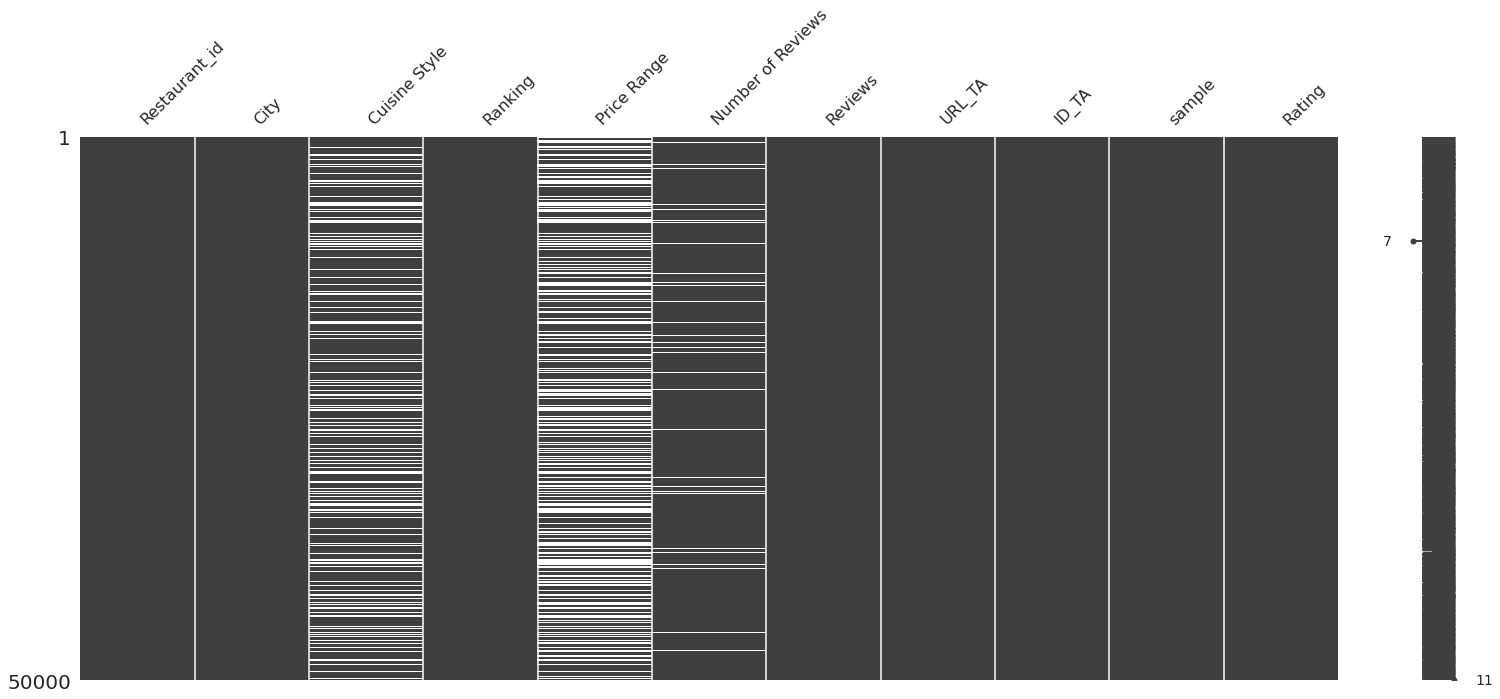

In [54]:
msno.matrix(data)

**Are the any duplicated rows in the dataset?**

In [13]:
print('Fortunately, no duplicates exist' if data.duplicated().sum() == 0 else 'Yes, there are')

Fortunately, no duplicates exist


Descriptive statistics:

In [14]:
data.describe()

,Ranking,Number of Reviews,sample,Rating
count,50000.000000,46800.000000,50000.000000,50000.000000
mean,3664.427520,124.471197,0.800000,3.194430
std,3700.092452,294.114345,0.400004,1.705453
min,1.000000,2.000000,0.000000,0.000000
25%,972.000000,9.000000,1.000000,3.000000
50%,2278.000000,33.000000,1.000000,4.000000
75%,5241.000000,115.000000,1.000000,4.500000
max,16444.000000,9660.000000,1.000000,5.000000


**So at first sight the following columns have no missing values:**

* Restaurant_id

* Cuisine Style

* City

* Ranking

* Rating

* Reviews

* URL_TA



Columns have the following types:

In [15]:
for column in data.columns:
    print(f'dtype of {column} column is {type(data[column].iloc[0])}')

dtype of Restaurant_id column is <class 'str'>
dtype of City column is <class 'str'>
dtype of Cuisine Style column is <class 'str'>
dtype of Ranking column is <class 'numpy.float64'>
dtype of Price Range column is <class 'str'>
dtype of Number of Reviews column is <class 'numpy.float64'>
dtype of Reviews column is <class 'str'>
dtype of URL_TA column is <class 'str'>
dtype of ID_TA column is <class 'str'>
dtype of sample column is <class 'numpy.int64'>
dtype of Rating column is <class 'numpy.float64'>


In [16]:
df = data.copy(deep=True)
df.columns = ['rest_id', 'city', 'cuisine', 'ranking',
                'price_range', 'reviews_amount', 'reviews', 'url_ta',
                'id_ta', 'sample', 'rating']

In [17]:
df.head(2)

,rest_id,city,cuisine,ranking,price_range,reviews_amount,reviews,url_ta,id_ta,sample,rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0


Let's build basic functions to display information:

In [18]:
def show_unique(column):
    print(f"Number of unique values for '{column}' column: {df[column].nunique()}")
    print(f"\nUnique values in '{column}' column:\n {df[column].unique()}")

In [19]:
def missing(column):
    print(f"Number of missing values for column '{column}': {df[column].isna().sum()}")

**Next I will check each variable apart for some missing values, outliers or just incorrect information.**

## Restaurant ID

This value is unlikely to be informative but nevertheless, I will preprocess it as well for some reason.

In [20]:
show_unique('rest_id')

Number of unique values for 'rest_id' column: 13094

Unique values in 'rest_id' column:
 ['id_0' 'id_1' 'id_2' ... 'id_15736' 'id_12774' 'id_11658']


In [21]:
missing('rest_id')

Number of missing values for column 'rest_id': 0


There are to many unique ID numbers to check them all. So I will save myself from future headache by choosing only values which match a special regex pattern:

In [22]:
def id_check(cell):
    import re
    ptrn = re.compile(r'id_\d+')
    result = re.search(ptrn, cell)
    
    return result.group(0)

In [ ]:
df.rest_id = df.rest_id.apply(id_check)

Let's look at values now:

In [ ]:
show_unique('rest_id')

Actually, we can see that nothing changed but, at least, there is some confidence now that everything is OK with this column.

Now we can drop this column as it plays no role in the future ML model:

In [ ]:
df.drop(['rest_id'], axis=1, inplace=True)

In [ ]:
df.info()

## City

In [ ]:
show_unique('city')

In [ ]:
missing('city')

Top-10 cities by number of restaurants:

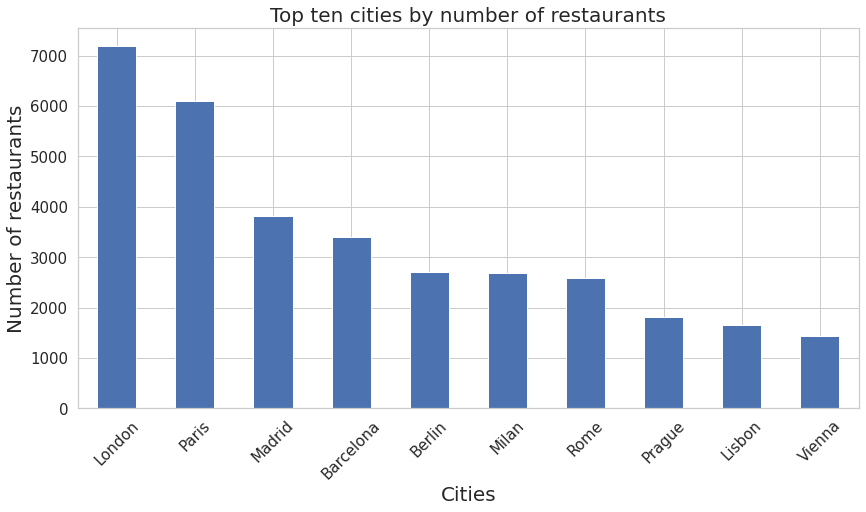

In [29]:
fig, ax = plt.subplots(figsize=(14, 7))
df.city.value_counts()[:10].plot(kind='bar')

plt.xticks(size=15, rotation=45)
plt.yticks(size=15)

ax.set_title('Top ten cities by number of restaurants', size=20)
ax.set_xlabel('Cities', size=20)
ax.set_ylabel('Number of restaurants', size=20)

* London and Paris cover the majority of restaurants

## Cuisine


In [30]:
show_unique('cuisine')

Number of unique values for 'cuisine' column: 10731

Unique values in 'cuisine' column:
 ["['Bar', 'Pub']"
 "['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"
 "['Vegetarian Friendly']" ...
 "['Steakhouse', 'Barbecue', 'Australian', 'Argentinean', 'South American']"
 "['French', 'American', 'Cafe', 'Healthy', 'Soups']"
 "['French', 'Contemporary', 'Fusion', 'Gastropub']"]


In [31]:
missing('cuisine')

Number of missing values for column 'cuisine': 11590


It would probably be informative to know how many different types of cuisine there are in dataset.

In [32]:
counter = Counter()
cuisine_df = data['Cuisine Style'].dropna().apply(ast.literal_eval)

for cuisines in cuisine_df:
    for cuisine in cuisines:
        counter[cuisine] += 1
        
print(f'{len(counter.keys())} different cuisines')

125 different cuisines


Which of cuisines is the most frequent?

In [33]:
print(f'{counter.most_common()[0][0]} - the most popular cuisine style')

Vegetarian Friendly - the most popular cuisine style


Mean amount of cuisines for each restaurant?

In [34]:
cuisine = data['Cuisine Style'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) else '1')
print(f'Mean amount of cuisines: {round(cuisine.apply(lambda x: len(x)).mean(), 2)}')

Mean amount of cuisines: 2.63


In [35]:
df_cuisine = df[['cuisine', 'city']]
df_cuisine

,cuisine,city
0,"['Bar', 'Pub']",Paris
1,"['European', 'Scandinavian', 'Gluten Free Opti...",Helsinki
2,['Vegetarian Friendly'],Edinburgh
3,"['Italian', 'Mediterranean', 'European', 'Vege...",London
4,"['Italian', 'Mediterranean', 'European', 'Seaf...",Bratislava
...,...,...
49995,"['Italian', 'Vegetarian Friendly', 'Vegan Opti...",Milan
49996,"['French', 'American', 'Bar', 'European', 'Veg...",Paris
49997,"['Japanese', 'Sushi']",Stockholm
49998,"['Polish', 'European', 'Eastern European', 'Ce...",Warsaw


If you use several links to check web-pages of restaurants which don't have any info about **cuisine**, you will make sure that usually this info doesn't actually exist even on TripAdvisor:

In [36]:
df[df.cuisine.isna()].url_ta.unique()[:10]

array(['/Restaurant_Review-g274887-d8286886-Reviews-Beer_N_Scooter-Budapest_Central_Hungary.html',
       '/Restaurant_Review-g187791-d7818546-Reviews-Jerry_Thomas_Speakeasy-Rome_Lazio.html',
       '/Restaurant_Review-g187331-d1344523-Reviews-Il_Cammino-Hamburg.html',
       '/Restaurant_Review-g190454-d8435085-Reviews-Angkor_Club-Vienna.html',
       '/Restaurant_Review-g187497-d8334752-Reviews-Restaurante_Laumon-Barcelona_Catalonia.html',
       '/Restaurant_Review-g187514-d13202032-Reviews-Wan-Madrid.html',
       '/Restaurant_Review-g187497-d5795143-Reviews-La_Bona_Taula_de_Llica-Barcelona_Catalonia.html',
       '/Restaurant_Review-g187147-d11953078-Reviews-Bistrot_Wattignies-Paris_Ile_de_France.html',
       '/Restaurant_Review-g186338-d13234520-Reviews-The_Granary_Brasserie-London_England.html',
       '/Restaurant_Review-g190479-d12170920-Reviews-Kaffegutta-Oslo_Eastern_Norway.html'],
      dtype=object)

Filling these missing values with an empty list for now :

In [37]:
cuisine = df.cuisine
df.cuisine.fillna('[]', inplace=True)

When dealing with these NaN-values it makes sense to pay attention to the city where the restaurant is located. Probably, this info will allow to fill those values approximately.

Now let's get **the most common cuisine** for each city:

In [38]:
df_cuisine.groupby(['city']).cuisine.value_counts()

city       cuisine                                                                                           
Amsterdam  ['Dutch', 'European']                                                                                 33
           ['Asian', 'Indonesian']                                                                               15
           ['Italian']                                                                                           14
           ['International']                                                                                     13
           ['Italian', 'Pizza', 'European', 'Vegetarian Friendly']                                               13
                                                                                                                 ..
Zurich     ['Swiss', 'Seafood', 'European', 'Central European', 'Vegetarian Friendly', 'Gluten Free Options']     1
           ['Swiss']                                                          

In [39]:
new_cuisine = df_cuisine.groupby(['city']).agg(lambda x: x.value_counts().index[0])
new_cuisine.head()

,cuisine
city,
Amsterdam,"['Dutch', 'European']"
Athens,['Greek']
Barcelona,['Spanish']
Berlin,['Italian']
Bratislava,['Pub']


In [40]:
def fill_cuisine(row):
    '''
    This function substitutes the missing value
    with the most common value for a certain city
    '''
    if pd.isna(row['cuisine']):
        row['cuisine'] = new_cuisine.loc[row['city']].iloc[0]

    return row

In [41]:
df = df.apply(fill_cuisine, axis=1)
df.head(2)

,city,cuisine,ranking,price_range,reviews_amount,reviews,url_ta,id_ta,sample,rating
0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0


In [42]:
print(f'Number of missing values for "cuisine" column: {new_data.cuisine.isna().sum()}')

NameError: name 'new_data' is not defined

So we filled the values of 'cuisine' column with the most frequent value for each city.

Later it will be more obvious whether this helped to **enhance the model quality or not**.

In [ ]:
df.info()

## Ranking

In [ ]:
show_unique('ranking')

In [ ]:
missing('ranking')

Everything is nice with this variable despite the fact that it should be of **int type** rather than float type:

In [ ]:
df.ranking = df.ranking.astype('int')

In [ ]:
df.sample(5)

Let's check this variable for some strange values (maybe outliers) by cities:

In [ ]:
for city in df.city.unique():
    fig = plt.figure(figsize=(18, 5))
    ax_1 = plt.subplot(1, 2, 1)
    sns.boxplot(df[df['city'] == city]['ranking'])
    ax_1.set_title(f'Boxplot for {city} restaurants ranking', size=15)
    
    ax_2 = plt.subplot(1, 2, 2)
    sns.distplot(df[df['city'] == city]['ranking'])
    ax_2.set_title(f'Distribution plot for {city} restaurants ranking', size=15)

* The distribution of ranking differs depending on cities

* Sometimes it is normal, sometimes binomial, sometimes just assymetrical

In [ ]:
print(f'Number of zero ranks: {(new_data.ranking == 0).sum()}')

So, these are ranks and they seem to be quite adequate.

## Rating (!)

In [ ]:
show_unique('rating')

In [ ]:
missing('rating')

Defining a function to display boxplot and distplot for numerical values:

In [ ]:
def dist_box(series):
    fig = plt.figure(figsize=(18, 5))
    ax_1 = plt.subplot(1, 2, 1)
    ax_2 = sns.distplot(series, bins=10)
    plt.yticks(size=15)
    plt.xticks(size=15)
    ax_1.set_ylabel('Frequency', size=13)
    ax_1.set_xlabel(f'{series.name}', size=13)
    ax_1.set_title(f'{series.name} distribution', size=13)

    ax_2 = plt.subplot(1, 2, 2)
    ax_2 = sns.boxplot(series)
    plt.yticks(size=15)
    plt.xticks(size=15)
    ax_2.set_xlabel(f'{series.name}', size=13)
    ax_2.set_title(f'{series.name} boxplot', size=13)

In [ ]:
dist_box(df[df.rating > 0]['rating'])

It is noticable that **rating has approximately normal distribution** provided that there are no values less than **3.0**.

Let's check the normality of its distribution using QQ-Plot:

In [ ]:
sm.qqplot(df[df.rating > 2.5].rating, stats.norm, fit=True, line='45')
plt.show()

In [ ]:
print(f'There are {df[(df.rating < 2.5) & (df.rating != 0)].rating.count()} <outliers> in "rating" column')

In [ ]:
# fig, ax = plt.subplots(figsize=(14, 6))
# new_df[new_df.rating > 0].rating.plot(kind='hist', bins=6)

* After deleting the values less than **2.5** we got a distribution of the **target variable** close to normal

In [ ]:
df.info()

Despite the fact that according to IQR values **1** and **1.5** are considered as outliers they are actually not. If we go to [TripAdvisor](https://www.tripadvisor.com/), we can get convinced that these values can be observed, probably, they are just rare.

## Price range

In [ ]:
show_unique('price_range')

In [ ]:
missing('price_range')

It is better to create some comprehensible categories like this:

In [ ]:
df.price_range = df.price_range.map({'$': 'low', '$$ - $$$': 'medium', '$$$$': 'high', np.nan: 'no price'})
df.sample(3)

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(df.price_range)

* The majority of restaurants have medium price level

What if the price range can be defined by the mean amount of reviews? Let's try to figure out if there are statistically significant differences:

In [ ]:
for value in sorted(new_data.price_range.dropna().unique()):
    print(f"Mean amount of reviews for category '{value}': {new_data[(new_data.price_range == value) & (new_data.reviews_amount < 2000)].reviews_amount.mean()}")

So, probably, the more expensive the restaurant is, the more reviews it has. Let's check amount of reviews for normal distribution:

In [ ]:
dist_box(df.reviews_amount)

In [ ]:
print(f'Amount of reviews > 2000: {df[df.reviews_amount > 2000].reviews_amount.count()} observations')

So this is not even close to normal distribution. That is why it is better to use **Mann-Whitney rank** test rather than Student's t-test since it is quite robust to the type if distribution.

* The **null hypothesis (H0)** is that there are no significant differences between these groups;

* The **alternative (Ha)** is that there are significant differences.

In [ ]:
for pair in combinations(sorted(df.price_range.dropna().unique()), 2):
    p_value = scipy.stats.mannwhitneyu(df[df.price_range == pair[0]].reviews_amount,
                                       df[df.price_range == pair[1]].reviews_amount).pvalue / 3
    if p_value < 0.05:
        print(f'Significant differences were found between groups {pair}')

Since with 95% confidence we can assert that there are statistically significant differences in amounts of reviews for different price ranges, let's try to fill missing values in **'price_range'** column according to mean amounts of reviews:


In [ ]:
mean_1 = df_output[df_output.price_range == 1].reviews_amount.mean()
mean_2 = df_output[df_output.price_range == 2].reviews_amount.mean()

def fill_price(row):
    if pd.isna(row['price_range']) and not pd.isna(row['reviews_amount']):
        if row['reviews_amount'] <= mean_1:
            row['price_range'] = 1
        elif row['reviews_amount'] <= mean_2:
            row['price_range'] = 2
        else:
            row['price_range'] = 3
        
    return row

In [ ]:
df = df.apply(fill_price, axis=1)
df.head()

The ratio itself remains quite similar to the one before filling missing values:

In [ ]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(df.price_range)

In [ ]:
df.info()

## Amount of reviews

In [ ]:
show_unique('reviews_amount')

In [ ]:
missing('reviews_amount')

The distribution of this variable is not even close to normal and there are outliers according to IQR. But these values actually exist, so there is no reason do delete them yet.

In [ ]:
dist_box(df[df.reviews_amount < 3000].reviews_amount)

If you check out the following web-pages of restaurants with zero reviews you can see that **at this moment** there are actually no  reviews (or there are **a few**) and there is no information about **price range**. Since this dataset is not absolutely up-to-date, it makes sense to substitute NaN-values with **zero**: 

In [ ]:
df[df.reviews_amount.isna()].url_ta.unique()

In [ ]:
df.reviews_amount.fillna(value=0, inplace=True)

In [ ]:
df.info()

## Reviews

In [ ]:
show_unique('reviews')

In [ ]:
missing('reviews')

In [ ]:
df.reviews.sample(15)

If we check these two URLs where we have no info about reviews, we can see that there are actually some reviews on restaurants' web-pages:

In [ ]:
df[df.reviews.isna()].url_ta.unique()

It makes sense to create a new variable: **Dates of the latest reviews for each restaurant**.

Defining a function to extract dates using a regular expression:

In [ ]:
def get_dates(x):
    ptrn = r'\d{2}/\d{2}/\d{4}'
    result = re.findall(ptrn, x)
    
    if len(result) == 2:
        return [result[0], result[1]]
    elif len(result) == 1:
        return [result[0], np.nan]
    
    return [np.nan, np.nan]

Applying the function:

In [ ]:
review_dates = pd.DataFrame(df.reviews.dropna().apply(get_dates).to_list(), 
                            columns=['latest_review_1', 'latest_review_2'])
review_dates = review_dates.apply(pd.to_datetime)
review_dates.sample(5)

In [ ]:
df = pd.concat([df, review_dates], axis=1)
df.sample(10)

In [ ]:
df.info()

In [ ]:
print(f'Maximal difference between two latest review dates: {(df.latest_review_1 - df.latest_review_2).max()}')

In [ ]:
print(f'The latest review left on: {df.latest_review_1.max()}')

Let's create a new feature that will probably help us to understand the data better: **difference between the last two review dates**:

In [ ]:
df['review_dates_diff'] = df['latest_review_1'] - df['latest_review_2']
df.drop(['latest_review_1', 'latest_review_2'], axis=1, inplace=True)
df.sample(5)

There are some restaurants which have only one date, that is why the column with date differences can contain negative values. Let's get rid of them:

In [ ]:
df.review_dates_diff = df.review_dates_diff.dropna().dt.days.astype(int).apply(lambda x: 0 if x < 0 else int(x))

In [ ]:
df.head(2)

Now let's take a look at the distribution of this variable:

In [ ]:
dist_box(df.review_dates_diff)

Values more than 1000 seem to be quite unrealistic.

In [ ]:
print(f'Amount of values more than 1000: {df[df.review_dates_diff > 1000].review_dates_diff.count()}')

Since 382 values is a small part of the whole dataset, it is possible to delete these values considering them as outliers:

In [ ]:
df.review_dates_diff = df.review_dates_diff.apply(lambda x: np.nan if x > 1000 else x)

Since there are no reviews (and dates), it is probably sensible to fill missing date differences with zero:

In [ ]:
df.review_dates_diff.fillna(value=0, inplace=True)

In [ ]:
df.info()

## URL on TripAdvisor

In [ ]:
show_unique('url_ta')

In [ ]:
missing('url_ta')

**No ideas how to use this information yet, so I will proceed to the next step for now.**

In [ ]:
# lst = []
# for url in urls[:100]:
#     url = 'https://www.tripadvisor.com' + url
#     page = requests.get(url)
#     html = BS(page.content, 'html.parser').text
#     lst.append(re.search(ptrn, html).group(0))
# lst

In [ ]:
new_df.sample(5)

In [ ]:
new_df.drop(['url_ta'], axis=1, inplace=True)

## ID number on TripAdvisor

This feature gives no additional information for the future model now, so deleting this one makes sense:

In [ ]:
new_df.drop(['id_ta'], axis=1, inplace=True)

# Feature Engineering

There is already one new feature which shows how many days passed between two latest reviews on restaurant's web-page.

Now it makes sense go deeper and dig the data for some new features.

In [ ]:
new_df.sample(5)

In [ ]:
new_df.info()

## Length of last two reviews

Let's try to add a new feature: **mean amount of words in the last two reviews**. Probably if reviews are fake, they will contain less words.

First of all, let's get rid of dates from review column values:

In [ ]:
def delete_dates(x):
    ptrn = r'\d{2}/\d{2}/\d{4}'
    x = re.sub(ptrn, '', x)
    
    return x

In [ ]:
df.reviews = df.reviews.dropna().apply(delete_dates)
df.head()

Elements in columns **'cuisine'** and **'reviews'** are actually lists but, formally, they are strings.

So, let's format them in order to work with real lists:

In [ ]:
df.cuisine = df.cuisine.str.replace(pat=r"\[|\]|'", repl='', regex=True)
df.cuisine = df.cuisine.str.split(', ')

df.reviews = df.reviews.dropna().str.replace(pat=r",|\[|\]|'", repl='', regex=True)
df.reviews = df.reviews.dropna().str.split()

print(type(df.cuisine.iloc[0]) is list)
print(type(df.reviews.iloc[0]) is list)

In [ ]:
df.head()

In [ ]:
df['reviews'].fillna(value='', inplace=True)

In [ ]:
df['review_length'] = df['reviews'].apply(lambda x: len(x))
df.sample(2)

In [ ]:
df.info()

## Number of cuisines a restaurant has

> There is an assumption that the more cuisines the restaurant has, the worse its dishes (and therefore the rating) are because there is not just one cuisine which the restaurant specializes in. It is probably more difficult to be good at cooking all the dishes from different cuisines rather than being excellent in one cuisine.

The idea is to count **how many different cuisines a restaurant has** and put this values into a new vector-column.

In [ ]:
df['cuisines_amount'] = df['cuisine'].apply(lambda x: len(x))
df.head(2)

In [ ]:
df.corr()

In [ ]:
new_df.info()

## Annual number of tourists for each city

Let's try to add some information about tourist flow from [Wikipedia](https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors) and Google.

I created a file containing information from Wikipedia about most of the cities we have in our dataset. Nevertheless, some of the cities are absent, so it is necessary to use google for additional info.

In [ ]:
cities = df.city.unique()

In [ ]:
tourists_by_city = {}

In [ ]:
tourism = pd.read_csv('../input/tourism/tourism.txt', sep='\t', header=None, usecols=[2, 4, 5])  
tourism.columns=['city', '2018', '2016']
tourism.city = tourism.city.str.strip().replace({'Porto': 'Oporto', 'Kraków': 'Krakow'})
tourism = tourism.set_index('city')

In [ ]:
for city in cities:
    if city in tourism.index:
        if not pd.isna(tourism.loc[city]['2018']):
            tourists_by_city[city] = int(tourism.loc[city]['2018'].replace(',', ''))
        elif not pd.isna(tourism.loc[city]['2016']):
            tourists_by_city[city] = int(tourism.loc[city]['2016'].replace(',', ''))
    else:
        tourists_by_city[city] = 0
        

The dictionary is almost complete:

In [ ]:
tourists_by_city

Filling missed cities:

In [ ]:
tourists_by_city['Bratislava'] = 125500
tourists_by_city['Hamburg'] = 1450000
tourists_by_city['Zurich'] = 2240000
tourists_by_city['Lyon'] = 6000000
tourists_by_city['Oslo'] = 4800000
tourists_by_city['Helsinki'] = 4000000
tourists_by_city['Edinburgh'] = 2015000
tourists_by_city['Geneva'] = 1050000
tourists_by_city['Ljubljana'] = 6200000
tourists_by_city['Luxembourg'] = 1139

So now there is a full dictionary with city-tourists pairs and it is time to add this info to TA Dataset:

In [ ]:
def tourists_amount(row):
    row['tourists'] = tourists_by_city[row['city']]
    
    return row

In [ ]:
new_df.city.unique()

In [ ]:
df['tourists'] = pd.Series(np.array([0 for i in range(len(df))]))
df = df.apply(tourists_amount, axis=1)

In [ ]:
df.sample(2)

In [ ]:
fig = plt.figure(figsize=(14, 6))
sns.heatmap(df.corr(), annot=True)

## Living standards ranking

Another variable I would like to add to the dataframe is the **quality of living ranking** which is provided by a famous consulting company [Mercer](https://mobilityexchange.mercer.com/Insights/quality-of-living-rankings).

The first step is to create a CSV file with that table from Mercer's report:

In [ ]:
ls = pd.read_csv('../input/living-standards/living_standards.txt', sep='\t')
ls

The second step is to extract only necessary cities:

In [ ]:
ls = ls[ls['City'].isin(list(df.city.unique()))][['Rank', 'City']]
ls.columns = ['city_rank', 'city']
print(ls.shape)
display(ls.head(5))

In [ ]:
ls.info()

Since ctities' ranks are objects, it is important to format them to int type:

In [ ]:
ls.city_rank = ls.city_rank.astype(int)

In [ ]:
ls.city.unique()

Obviously, there are only 2 cities which were not included in this report:

In [ ]:
set(df.city.unique()).difference(set(ls.city.unique()))

In [ ]:
number = len(df[df.city.isin(['Krakow', 'Oporto'])])
print(f'Number of restaurants from Krakow and Oporto: {number}')

Let's try to merge living standards with initial dataframe:

In [ ]:
df = df.merge(ls, how='left', on='city')
df.shape

In [ ]:
df.head(2)

In [ ]:
df.corr()

The correlation between **review dates difference, review_length, tourists, city_rank** and **rating** is weak. It is probably better to drop it.

In [ ]:
# new_df = df.drop(['review_dates_diff', 'tourists', 'city_rank', 'review_length'], axis=1)

In [ ]:
new_df.info()

## Dummy price range

In [ ]:
new_df.head(1)

Now, let's see if there are significant differences between the ratings of restaurants depending on their price range or city.

For this purposes Student's t-test can be used since the data in **'rating'** column is normally distributed.

In [ ]:
for column in ['city', 'price_range']:
    combs =  combinations(list(df[column].dropna().unique()), 2)
    for comb in combs:
        p_value = stats.ttest_ind(df[df[column] == comb[0]].rating.dropna(),
                                  df[df[column] == comb[1]].rating.dropna()).pvalue
        if (p_value / len(list(combs))) < 0.05:
            print(f'Statistically significant differences found for column \"{column}\"')
            break


**Getting dummies for price range:**

In [ ]:
df = pd.get_dummies(df, columns=['price_range'])

## Dummy vegan cuisine

Since vegetarian cuisine is the most frequent, let's try to make a dummy variable where:
* **1** - it is a vegetarian cuisine,
* **0** - it is not

In [ ]:
dummy_veg = pd.DataFrame(new_df.cuisine.astype(str).str.contains('Veg').astype(int))
new_df['dummy_veg'] = dummy_veg

In [ ]:
new_df.head(1)

## Dummy most frequent cities

Probably, reference to a popular city will help to define our target variable:

In [ ]:
new_df['pop_city'] = new_df.city.astype(str).str.contains(r'London|Paris', regex=True).astype(int)
new_df.sample(4)

In [ ]:
new_df.info()

## Dummy chain restaurant

Probably, the rating also depends on whether it is a chain of restaurants or not. 

I will consider a restaurant as a chain one if it occurs more than 5 times in dataset.

In [ ]:
new_df['id_ta'] = data['ID_TA']
new_df['rest_id'] = data['Restaurant_id']

In [ ]:
new_df['chain'] = new_df.rest_id.map(dict((new_df.rest_id.value_counts() > 5).astype(int)))
new_df.head(5)

In [ ]:
new_df.drop(['rest_id', 'id_ta', 'url_ta'], axis=1, inplace=True)
new_df.info()

Finally, a correlation matrix will show approximately which features are significant:

In [ ]:
fig = plt.figure(figsize=(14, 6))
sns.heatmap(new_df.drop(['sample', 'chain', 'dummy_veg', 'pop_city'], axis=1).corr(), annot=True)

* Review dates difference only makes the model work worse

* 

# Data preprocessing - function

Creating a function which contains all the steps of preprocessing for better reproducibility and convenience 

In [55]:
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1
df_test['sample'] = 0 
df_test['Rating'] = 0 

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

cities = data.City.unique()
tourists_by_city = {}
tourism = pd.read_csv('../input/tourism/tourism.txt', sep='\t', header=None, usecols=[2, 4, 5])  
tourism.columns=['city', '2018', '2016']
tourism.city = tourism.city.str.strip().replace({'Porto': 'Oporto', 'Kraków': 'Krakow'})
tourism = tourism.set_index('city')

for city in cities:
    if city in tourism.index:
        if not pd.isna(tourism.loc[city]['2018']):
            tourists_by_city[city] = int(tourism.loc[city]['2018'].replace(',', ''))
        elif not pd.isna(tourism.loc[city]['2016']):
            tourists_by_city[city] = int(tourism.loc[city]['2016'].replace(',', ''))
    else:
        tourists_by_city[city] = 0  
        
tourists_by_city['Bratislava'] = 125500
tourists_by_city['Hamburg'] = 1450000
tourists_by_city['Zurich'] = 2240000
tourists_by_city['Lyon'] = 6000000
tourists_by_city['Oslo'] = 4800000
tourists_by_city['Helsinki'] = 4000000
tourists_by_city['Edinburgh'] = 2015000
tourists_by_city['Geneva'] = 1050000
tourists_by_city['Ljubljana'] = 6200000
tourists_by_city['Luxembourg'] = 1139

ls = pd.read_csv('../input/living-standards/living_standards.txt', sep='\t')
ls = ls[ls['City'].isin(list(data.City.unique()))][['Rank', 'City']]
ls.columns = ['city_rank', 'city']
ls.city_rank = ls.city_rank.astype(int)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


In [59]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Preprocessing ############################################################## 

    df_output.columns = ['rest_id', 'city', 'cuisine', 'ranking',
                'price_range', 'reviews_amount', 'reviews', 'url_ta',
                'id_ta', 'sample', 'rating']
    df_output.drop(['id_ta', 'url_ta'], axis = 1, inplace=True)
    
    
    
    # ################### 2. NAN ############################################################## 
    # Cuisine
    df_output.cuisine.fillna('[]', inplace=True)

    # Amount of reviews
    df_output.reviews_amount.fillna(value=0, inplace=True)
    
    # Rating
#     df_output = df_output[(df_output.rating > 3) | (df_output.rating == 0)]

    
    
    # ################### 3. Encoding ############################################################## 
    # Dummy most popular city
#     df_output['pop_city'] = df_output.city.astype(str).str.contains(r'London|Paris', regex=True).astype(int)
    
    # Dummy City
#     df_output = pd.concat([df_output, pd.get_dummies(df_output.city)], axis=1)
    
    # Dummy Price Range
    df_output.price_range = df_output.price_range.map({'$': 'low', '$$ - $$$': 'medium', '$$$$': 'high', np.nan: 'no price'})
    df_output = pd.get_dummies(df_output, columns=['price_range'])
    
    # Dummy vegan cuisine
#     dummy_veg = pd.DataFrame(df_output.cuisine.astype(str).str.contains('Veg').astype(int))
#     df_output['dummy_veg'] = dummy_veg
    
    # Dummy chain restaurant
#     df_output['chain'] = df_output.rest_id.map(dict((df_output.rest_id.value_counts() > 5).astype(int)))
#     df_output.drop(['rest_id'], axis=1, inplace=True)
    
    # ################### 4. Feature Engineering ####################################################
    # Cuisines amount
    df_output['cuisines_amount'] = df_output['cuisine'].apply(lambda x: len(x))
    
#     Annual number of tourists
    def tourists_amount(row):
        row['tourists'] = tourists_by_city[row['city']]
        return row
    
    
    df_output['tourists'] = pd.Series(np.array([0 for i in range(len(df_output))]))
    df_output = df_output.apply(tourists_amount, axis=1)
    
    # City quality rank
    df_output = df_output.merge(ls, how='left', on='city')
    df_output['city_rank'].fillna(method='bfill', inplace=True)
    
    
    # ################### 5. Clean #################################################### 
    ranking = df_output[['city', 'ranking']]
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    minmax_scale = MinMaxScaler(feature_range=(0, 1))
    for column in df_output.columns:
        if column not in ['rating', 'ranking']:
            df_output[[column]] = minmax_scale.fit_transform(df_output[[column]])
               
    def scaler(x):
        x_scaled = (x - np.min(x)) / (np.max(x) - np.min(x))
        return x_scaled
    
    df_output['ranking'] = ranking.groupby('city')['ranking'].apply(lambda x: scaler(x))
    
    
    return df_output

**Since everything is scaled, the model can be built:**

In [60]:
df_preproc = preproc_data(data).dropna()
df_preproc.sample(10)

train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

In [61]:
y = train_data.rating.values
X = train_data.drop(['rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)


model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


MAE: 0.20447374999999998


In [62]:
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 41), (40000, 41), (40000, 40), (32000, 40), (8000, 40))

In [63]:
df_preproc.sample(10)

,ranking,reviews_amount,sample,rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,...,Vienna,Warsaw,Zurich,price_range_high,price_range_low,price_range_medium,price_range_no price,cuisines_amount,tourists,city_rank
49241,0.373789,0.003106,1.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.183979,0.409091
15543,0.125568,0.022050,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.195402,0.282810,0.511364
28366,0.610637,0.002277,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.022989,0.135372,0.250000
16968,0.934049,0.001863,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.038314,0.271022,0.363636
14979,0.298827,0.002277,1.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.107280,0.159556,0.079545
43681,0.019023,0.013458,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.229885,0.913019,0.431818
16443,0.340413,0.023913,1.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.233716,0.913019,0.431818
5663,0.298036,0.002381,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.349075,0.477273
7398,0.785942,0.004555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.068966,0.523312,0.625000
39770,0.062897,0.043996,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.298851,0.282810,0.511364


In [64]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 10000 to 49999
Data columns (total 41 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ranking               40000 non-null  float64
 1   reviews_amount        40000 non-null  float64
 2   rating                40000 non-null  float64
 3   Amsterdam             40000 non-null  float64
 4   Athens                40000 non-null  float64
 5   Barcelona             40000 non-null  float64
 6   Berlin                40000 non-null  float64
 7   Bratislava            40000 non-null  float64
 8   Brussels              40000 non-null  float64
 9   Budapest              40000 non-null  float64
 10  Copenhagen            40000 non-null  float64
 11  Dublin                40000 non-null  float64
 12  Edinburgh             40000 non-null  float64
 13  Geneva                40000 non-null  float64
 14  Hamburg               40000 non-null  float64
 15  Helsinki       

Displaying the most important variables:

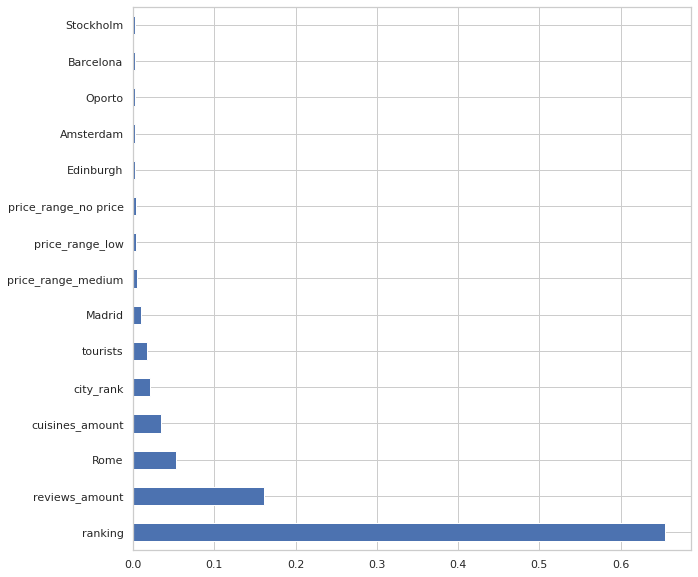

In [65]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Submission

In [66]:
test_data.sample(10)

,ranking,reviews_amount,rating,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,...,Vienna,Warsaw,Zurich,price_range_high,price_range_low,price_range_medium,price_range_no price,cuisines_amount,tourists,city_rank
8080,0.553556,0.007350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.260536,0.523312,0.625000
915,0.742138,0.000207,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.349075,0.477273
2173,0.311350,0.003520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.291188,0.271022,0.363636
5823,0.861582,0.001035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.034483,1.000000,0.454545
2076,0.616892,0.000311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.913019,0.431818
5974,0.501383,0.005280,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.126437,0.434335,0.113636
6644,0.028282,0.116874,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.429119,0.434335,0.113636
3468,0.045905,0.229710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.455939,0.523312,0.625000
5383,0.349353,0.003830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.030651,0.913019,0.431818
7956,0.148773,0.023292,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.421456,0.271022,0.363636


In [67]:
test_data = test_data.drop(['rating'], axis=1)

In [68]:
sample_submission.sample(20)


,Restaurant_id,Rating
9140,id_9140,5.0
1349,id_1349,2.5
5456,id_5456,4.0
3579,id_3579,2.5
8871,id_8871,1.0
5300,id_5300,4.5
8119,id_8119,4.5
4333,id_4333,1.5
7329,id_7329,2.5
222,id_222,3.0


In [69]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [70]:
predict_submission

array([3.01 , 4.285, 4.485, ..., 3.075, 4.475, 4.205])

In [71]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.010
1,id_1,4.285
2,id_2,4.485
3,id_3,4.360
4,id_4,4.480
5,id_5,4.575
6,id_6,1.640
7,id_7,3.675
8,id_8,4.230
9,id_9,4.685


In [ ]:
conda install CVXcanon  